In [1]:
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt

# k sample testing from hyppo
from hyppo.ksample import KSample
from hyppo.tools import rot_ksamp

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from math import log2, ceil

In [2]:
# samples to use per distribution
n_samples = 1000
# define number of estimators to use
n_trees = 10
# angles to pass to rxor
angle_sweep = range(0, 95, 5)

In [3]:
##### task unaware #####
# dictionary to store task_id's for multiple reps
mult_rep_id_dict = {}
# generate task xor
X_xor, y_xor = generate_gaussian_parity(n_samples)
# generate test data
X_xor_test, y_xor_test = generate_gaussian_parity(n_samples)
# add xor data to dict
mult_rep_id_dict[0] = X_xor, y_xor
# arrays to store gen error
pl_ge = np.zeros(19)
pl_ge_t0 = np.zeros(19)
uf1_ge = np.zeros(19)
# testing with multiple runs
for rep, angle in enumerate(angle_sweep):
    X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.radians(angle))
    # train single run of model
    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    # add xor data
    progressive_learner.add_task(
        mult_rep_id_dict[rep][0], mult_rep_id_dict[rep][1], n_estimators=n_trees
    )
    # init second LifeLongClassificationForest
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

    # k sample test, add new task rxor and learn new transformer if p <= 0.05
    if KSample(indep_test="Dcorr").test(mult_rep_id_dict[rep][0], X_rxor)[1] <= 0.05:
        progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees)
        progressive_learner.add_transformer(X_rxor, y_rxor, n_estimators=n_trees)
        uf1.add_task(X_rxor, y_rxor, n_estimators=2 * n_trees)

        # calc errors

        pl_ge[rep] = 1 - np.mean(
            progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
        )
        pl_ge_t0[rep] = 1 - np.mean(
            progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
        )
        uf1_ge[rep] = 1 - np.mean(uf1.predict(X_xor_test, task_id=0) == y_xor_test)

        # X_xor_rxor = np.concatenate((mult_rep_id_dict[rep][0], X_rxor), axis=0)
        # y_xor_rxor = np.concatenate((mult_rep_id_dict[rep][1], y_rxor), axis=0)
        # mult_rep_id_dict[rep + 1] = X_xor_rxor, y_xor_rxor
        # pass previous concatted data since we learned a new task
        mult_rep_id_dict[rep + 1] = mult_rep_id_dict[rep]

    else:
        # else add concatenated xor and rxor data
        X_xor_rxor = np.concatenate((mult_rep_id_dict[rep][0], X_rxor), axis=0)
        y_xor_rxor = np.concatenate((mult_rep_id_dict[rep][1], y_rxor), axis=0)
        progressive_learner.add_task(X_xor_rxor, y_xor_rxor, n_estimators=n_trees)
        uf1.add_task(X_xor_rxor, y_xor_rxor, n_estimators=2 * n_trees)
        mult_rep_id_dict[rep + 1] = X_xor_rxor, y_xor_rxor

        # calc gen erros
        pl_ge[rep] = 1 - np.mean(
            progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
        )
        pl_ge_t0[rep] = 1 - np.mean(
            progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
        )
        uf1_ge[rep] = 1 - np.mean(uf1.predict(X_xor_test, task_id=0) == y_xor_test)

    # print(progressive_learner.get_task_ids(), uf1.get_task_ids())

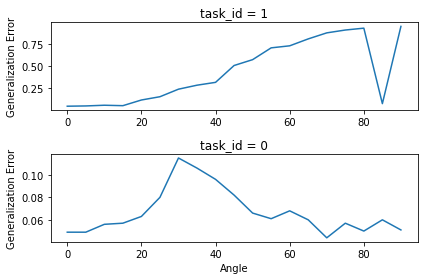

In [4]:
# fig, (ax1, ax2, ax3) = plt.subplots(3)
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(angle_sweep, pl_ge)  # task_id = 1
ax1.set_title("task_id = 1")
ax1.set_ylabel("Generalization Error")
ax2.plot(angle_sweep, pl_ge_t0)  # task_id = 0
ax2.set_title("task_id = 0")
ax2.set_xlabel("Angle")
ax2.set_ylabel("Generalization Error")
fig.tight_layout()
# fig.savefig('task_unaware_gen_error2.pdf')
# ax3.plot(angle_sweep, uf1_ge) # new learner with only new data as task

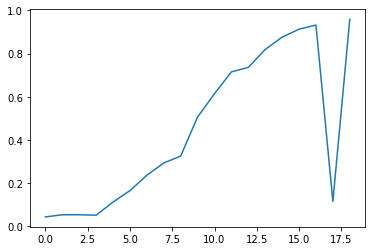

In [5]:
# uf1
plt.plot(uf1_ge)

In [6]:
# define dictionary for task aware case to pass on prev data
task_aware_dict = {}
# add first xor data
task_aware_dict[0] = X_xor, y_xor
# arrays to store gen error
aware_pl_ge = np.zeros(19)
aware_pl_ge_t0 = np.zeros(19)

In [7]:
##### task aware experiment #####
for i, angle in enumerate(angle_sweep):
    # init progressive learner
    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    # add first data
    progressive_learner.add_task(
        task_aware_dict[i][0], task_aware_dict[i][1], n_estimators=n_trees
    )

    # generate rxor data
    X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.radians(angle))
    # add as task to leaner
    progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees)

    # concat the data to be passed on
    X_xor_rxor = np.concatenate((mult_rep_id_dict[i][0], X_rxor), axis=0)
    y_xor_rxor = np.concatenate((mult_rep_id_dict[i][1], y_rxor), axis=0)
    task_aware_dict[i + 1] = X_xor_rxor, y_xor_rxor
    
    # calc gen errors
    aware_pl_ge[i] = 1 - np.mean(
        progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
    )
    aware_pl_ge_t0[i] = 1 - np.mean(
        progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
    )

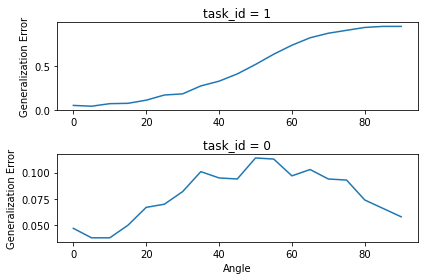

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(angle_sweep, aware_pl_ge)  # using task_id = 1
ax1.set_title("task_id = 1")
ax1.set_ylabel("Generalization Error")
ax2.plot(angle_sweep, aware_pl_ge_t0)  # using task_id = 0
ax2.set_title("task_id = 0")
ax2.set_xlabel("Angle")
ax2.set_ylabel("Generalization Error")
fig.tight_layout()
# fig.savefig('task_aware_gen_error.pdf')